In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [285]:
class Car(object):
    def __init__(self):
        self.track = pd.read_csv('track.txt',sep=' ')
        self.kdtree = KDTree(self.track)
        self.__reset__()

    def __reset__(self):
        self.max_steering_deg = 25
        self.min_steering_deg = -25
        self.min_speed = 0 #meter per second
        self.max_speed = 50 #meter per second
        self.speed = 0 #meter per second
        self.steering_deg = 0 #degree
        self.heading_deg = 0 #degrees
        self.x = self.track.x[0]
        self.y = self.track.y[0]
        self.length = 1.0 # length of vehicle in meter
        self.trip_length = 0.0 #meters
        
    def render(self):
        plt.figure(figsize=(12,8))
        plt.scatter(self.track.x, self.track.y)
        plt.plot(self.track.x[0], self.track.y[0], 'go', markersize=12)
        plt.plot(self.x, self.y, 'r.', markersize=12)
        plt.show()
        
    
    def _to_rad_(deg):
        return deg * np.pi / 180
    
    def _to_deg_(rad):
        return rad*180/np.pi
    
    def __check_off_track__(self):
        dist, ind = self.kdtree.query([[self.x, self.y]], 1)
        car = (round(self.x,2), round(self.y,2))
        closest_x = float(self.track.x[ind[0]])
        closest_y = float(self.track.y[ind[0]])
        closest = (round(closest_x,2),round(closest_y,2))
        assert dist <= 15,\
        f"Game Over!! Your car veered off the track after {self.trip_length}m! Car:{car} Closest Point:{closest}"
    
    def move(self, time_step):
        heading = Car._to_rad_(self.heading_deg)
        steering = Car._to_rad_(self.steering_deg)
        
        delta_x = self.speed*np.cos(heading)*time_step
        delta_y = self.speed*np.sin(heading)*time_step
        self.x = self.x + delta_x
        self.y = self.y + delta_y
     
        new_heading = (heading + self.speed / self.length * steering * time_step) % (np.pi * 2)
        if new_heading > np.pi:
            new_heading = new_heading - 2*np.pi
        elif new_heading < -np.pi:
            new_heading = 2*np.pi - new_heading
            
        self.heading_deg = Car._to_deg_(new_heading)
        
        self.trip_length += np.sqrt(delta_x**2 + delta_y**2)
        
        self.__check_off_track__()
    
        
    
    def set_steering(self, steer_deg):
        assert self.min_steering_deg <= steer_deg <= self.max_steering_deg,\
        f'Steering angle must be in degree and in the range {self.min_steering_deg},{self.max_steering_deg}'
        
        self.steering_deg = steer_deg
        
        
    def set_speed(self, speed_meter_sec):
        assert self.min_speed <= speed_meter_sec <= self.max_speed,\
        (f'Speed must be in meters per second and in the range {self.min_speed},{self.max_speed}')
        
        self.speed = speed_meter_sec
        
        
    
    def find_nearest_track_points(self,n=5):
        dist, inds = self.kdtree.query([[self.x, self.y]], n)
        inds = list(*inds)
        return self.track.loc[inds]
        

In [286]:
car = Car()

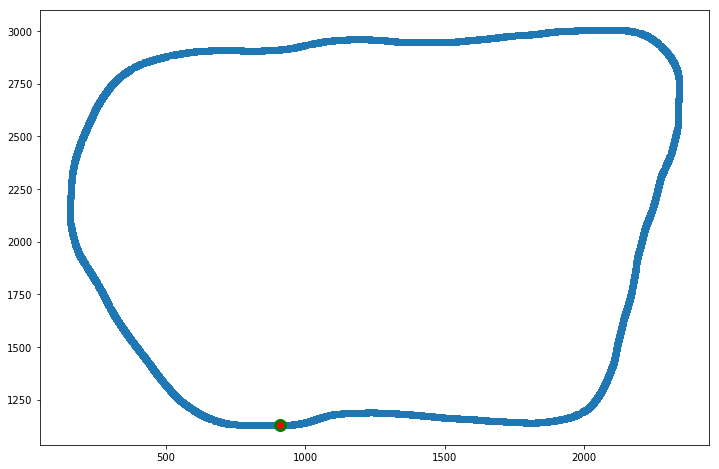

In [287]:
car.render()

73 steps.
Game Over!! Your car veered off the track after 148.0m! Car:(1056.07, 1147.59) Closest Point:(1050.24, 1161.62)


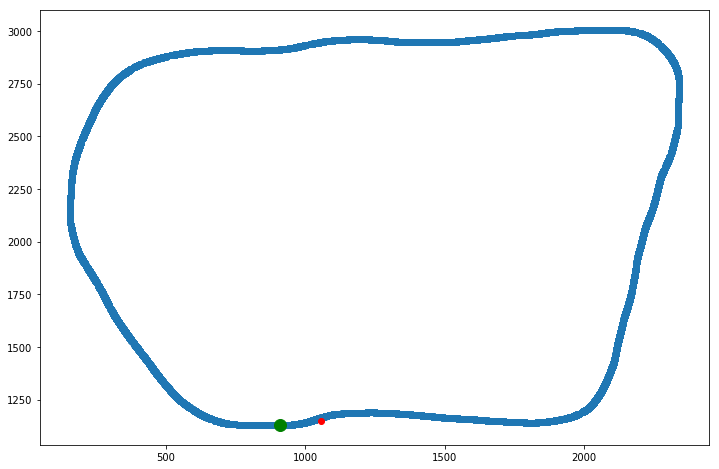

In [288]:
car.__reset__()
car.set_speed(20)
car.set_steering(0.1)

try:
    for i in range(150):
        car.move(.1)
except Exception as err:
    print(f'{i} steps.')
    print(err)
finally:
    car.render()

In [314]:
Kp=0.005
Kd=0.05
Ki=0.0000

Game Over!! Your car veered off the track after 2578.0m! Car:(2353.1, 2593.22) Closest Point:(2338.03, 2593.16)
1289 steps.


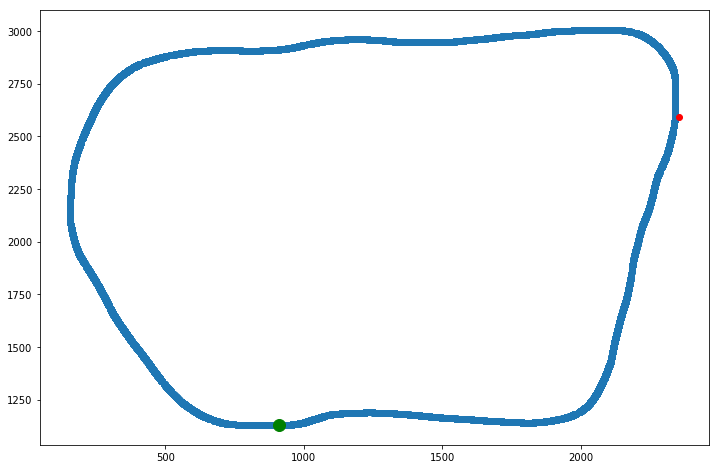

In [395]:
car.__reset__()
car.set_speed(20)
car.set_steering(0.1)

trajectory = []
controls = []
debug_log = {'desired_heading':[], 'current_heading':[], 'error':[], 'coeff':[], 'nearest_x':[], 'nearest_y':[]}
prev_error = 0
cuml_error = 0

try:
    for i in range(2000):
        nearest = car.find_nearest_track_points()
        coeffs = np.polyfit(nearest.x, nearest.y, 1)
        current_heading = car.heading_deg
        desired_heading = Car._to_deg_(np.arctan(coeffs[0]))
        error = (current_heading - desired_heading)
        if error > 180:
            error = error - 360
        elif error < -180:
            error = 360 - error
        
        debug_log['desired_heading'].append(desired_heading)
        debug_log['current_heading'].append(current_heading)
        debug_log['error'].append(error)
        debug_log['coeff'].append(coeffs[0])
        debug_log['nearest_x'].append(list(nearest.x))
        debug_log['nearest_y'].append(list(nearest.y))
        
        cuml_error = cuml_error + error
        new_steering_degree = car.steering_deg - Kp*error -Kd*(error - prev_error)-Ki*cuml_error
        prev_error = error
        if new_steering_degree > car.max_steering_deg:
            new_steering_degree = car.max_steering_deg
        elif new_steering_degree < car.min_steering_deg:
            new_steering_degree = car.min_steering_deg
                
        car.set_steering(new_steering_degree)
        trajectory.append((car.x,car.y))
        controls.append(new_steering_degree)
        car.move(.1)
        
        
except Exception as err:
    print(err)
finally:
    print(f'{i+1} steps.')
    car.render()

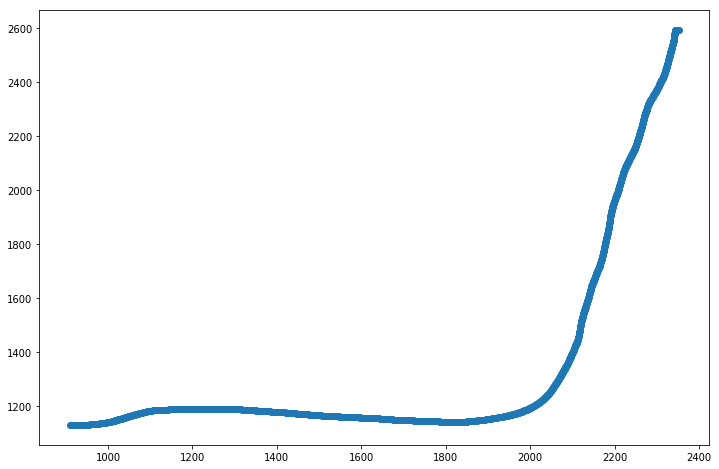

In [396]:
plt.figure(figsize=(12,8))
plt.scatter(*list(zip(*trajectory)))
plt.show()

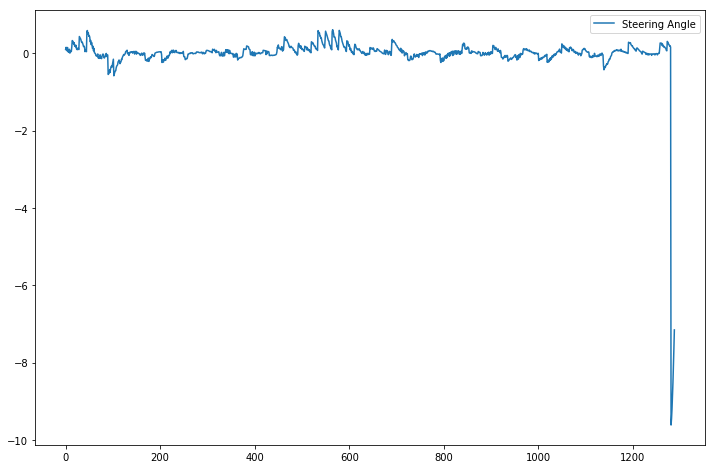

In [400]:
plt.figure(figsize=(12,8))
plt.plot(controls)
plt.legend(['Steering Angle'])
plt.show()

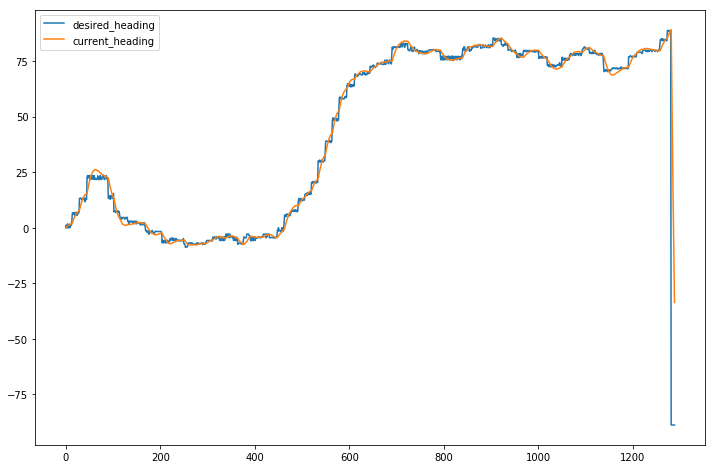

In [398]:
plt.figure(figsize=(12,8))
plt.plot(debug_log['desired_heading'])
plt.plot(debug_log['current_heading'])
plt.legend(['desired_heading','current_heading'])
plt.show()

In [392]:
log = pd.DataFrame(debug_log)

In [393]:
log

,coeff,current_heading,desired_heading,error,nearest_x,nearest_y
0,-5.205948e-13,0.000000,1.800000e+02,-180.000000,"[909.678, 909.738, 909.538, 909.878, 909.938]","[1128.84, 1128.84, 1128.84, 1128.84, 1128.84]"
1,2.119309e-02,20.000000,1.214093e+00,18.785907,"[911.678, 911.738, 911.538, 911.4780000000001,...","[1128.85, 1128.85, 1128.85, 1128.85, 1128.86]"
2,3.184211e-14,19.933550,1.824418e-12,19.933550,"[913.538, 913.4780000000001, 913.678, 913.738,...","[1128.87, 1128.87, 1128.87, 1128.87, 1128.87]"
3,1.805338e-02,19.553001,1.034270e+00,18.518731,"[915.4780000000001, 915.3380000000001, 915.538...","[1128.89, 1128.89, 1128.89, 1128.88, 1128.89]"
4,2.761152e-14,19.128746,1.582024e-12,19.128746,"[917.3380000000001, 917.278, 917.4780000000001...","[1128.9, 1128.9, 1128.9, 1128.9, 1128.9]"
5,6.723424e-14,18.452202,3.852238e-12,18.452202,"[919.278, 919.138, 919.3380000000001, 919.078,...","[1128.92, 1128.92, 1128.92, 1128.92, 1128.92]"
6,2.864992e-02,17.658790,1.641071e+00,16.017720,"[921.138, 921.278, 921.3380000000001, 921.078,...","[1128.94, 1128.94, 1128.94, 1128.93, 1128.93]"
7,5.866733e-14,16.948650,3.361390e-12,16.948650,"[923.078, 922.938, 923.138, 922.878, 923.278]","[1128.95, 1128.95, 1128.95, 1128.95, 1128.95]"
8,5.847183e-14,15.975930,3.350189e-12,15.975930,"[924.938, 924.878, 925.078, 924.738, 925.138]","[1128.97, 1128.97, 1128.97, 1128.97, 1128.97]"
9,2.119309e-02,14.940722,1.214093e+00,13.726629,"[926.878, 926.938, 927.078, 927.138, 926.738]","[1128.99, 1128.99, 1128.99, 1128.99, 1128.98]"


In [362]:
log[1280:].nearest_x

1280    [2338.07, 2338.06, 2338.06, 2338.06, 2338.05]
1281    [2338.07, 2338.07, 2338.07, 2338.07, 2338.06]
1282    [2338.07, 2338.06, 2338.06, 2338.06, 2338.07]
1283    [2338.04, 2338.05, 2338.04, 2338.04, 2338.05]
1284    [2338.03, 2338.02, 2338.02, 2338.02, 2338.03]
1285    [2338.01, 2338.01, 2338.01, 2338.01, 2338.02]
1286       [2338.01, 2338.0, 2338.0, 2338.01, 2338.0]
1287      [2338.01, 2338.01, 2338.0, 2338.0, 2338.01]
1288    [2338.02, 2338.01, 2338.01, 2338.01, 2338.02]
Name: nearest_x, dtype: object

In [363]:
log[1280:].nearest_y

1280    [2585.32, 2585.12, 2584.92, 2584.72, 2584.52]
1281    [2589.16, 2589.36, 2589.56, 2589.76, 2589.96]
1282    [2589.76, 2589.96, 2590.16, 2590.36, 2589.56]
1283    [2591.96, 2591.56, 2591.76, 2592.16, 2591.36]
1284    [2593.16, 2593.36, 2593.56, 2593.76, 2592.96]
1285    [2594.56, 2594.36, 2594.76, 2594.16, 2593.96]
1286    [2594.76, 2594.96, 2595.16, 2594.56, 2595.36]
1287    [2594.76, 2594.56, 2594.96, 2595.16, 2594.36]
1288    [2593.96, 2594.36, 2594.16, 2594.56, 2593.76]
Name: nearest_y, dtype: object

In [369]:
np.polyfit([2338.07, 2338.06, 2338.06, 2338.06, 2338.05],[2585.32, 2585.12, 2584.92, 2584.72, 2584.52],1)

array([ 4.000000e+01, -9.093748e+04])

In [370]:
np.polyfit([2338.07, 2338.07, 2338.07, 2338.07, 2338.06],[2589.16, 2589.36, 2589.56, 2589.76, 2589.96],1)

array([-5.0000000e+01,  1.1949296e+05])

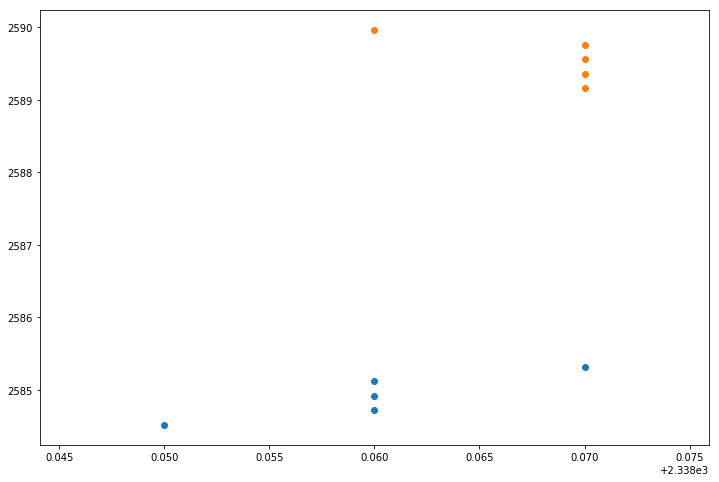

In [373]:
plt.figure(figsize=(12,8))
plt.scatter([2338.07, 2338.06, 2338.06, 2338.06, 2338.05],[2585.32, 2585.12, 2584.92, 2584.72, 2584.52])
plt.scatter([2338.07, 2338.07, 2338.07, 2338.07, 2338.06],[2589.16, 2589.36, 2589.56, 2589.76, 2589.96])

In [375]:
log[1280:]

,coeff,current_heading,desired_heading,error,nearest_x,nearest_y
1280,40.0,88.862194,88.567904,0.294291,"[2338.07, 2338.06, 2338.06, 2338.06, 2338.05]","[2585.32, 2585.12, 2584.92, 2584.72, 2584.52]"
1281,-50.0,89.183317,-88.854237,178.037554,"[2338.07, 2338.07, 2338.07, 2338.07, 2338.06]","[2589.16, 2589.36, 2589.56, 2589.76, 2589.96]"
1282,-50.0,69.949737,-88.854237,158.803974,"[2338.07, 2338.06, 2338.06, 2338.06, 2338.07]","[2589.76, 2589.96, 2590.16, 2590.36, 2589.56]"
1283,-50.0,51.051476,-88.854237,139.905713,"[2338.04, 2338.05, 2338.04, 2338.04, 2338.05]","[2591.96, 2591.56, 2591.76, 2592.16, 2591.36]"
1284,-50.0,32.643983,-88.854237,121.498220,"[2338.03, 2338.02, 2338.02, 2338.02, 2338.03]","[2593.16, 2593.36, 2593.56, 2593.76, 2592.96]"
1285,-50.0,14.862258,-88.854237,103.716495,"[2338.01, 2338.01, 2338.01, 2338.01, 2338.02]","[2594.56, 2594.36, 2594.76, 2594.16, 2593.96]"
1286,-50.0,-2.178460,-88.854237,86.675777,"[2338.01, 2338.0, 2338.0, 2338.01, 2338.0]","[2594.76, 2594.96, 2595.16, 2594.56, 2595.36]"
1287,-50.0,-18.381864,-88.854237,70.472374,"[2338.01, 2338.01, 2338.0, 2338.0, 2338.01]","[2594.76, 2594.56, 2594.96, 2595.16, 2594.36]"
1288,-50.0,-33.669651,-88.854237,55.184586,"[2338.02, 2338.01, 2338.01, 2338.01, 2338.02]","[2593.96, 2594.36, 2594.16, 2594.56, 2593.76]"
